In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats.stats as stats
import re
import math
from datetime import datetime
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time

import statsmodels.api as sm

In [ ]:
# !pip install mlxtend
# !pip install lightgbm

In [4]:
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning

In [5]:
df = pd.read_excel('data/ExcelFile_2021-11-01T10_29_59_self -employed.xlsx', sheet_name = 'Sheet1')

df['date_requested'] = pd.to_datetime(df['date_requested'])

In [6]:
# задание названия переменной, являющейся таргетом
TARGET = 'npl1_1_7dpd'
df = df[df[TARGET].isna() == False]

# Фильтрация требуемого сегмента
df = df[(df['product_group'] == 'MICRO_SELF_EMPLOYED')]

df['target'] = df[TARGET]
y = df[TARGET]

In [7]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
df, else_df = replace_not_frequent_2(df, cat_vars, num_min = min_num)

# Drop columns with only 1 value
df = drop_single_value_column(df)

In [8]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'SCOR' in var or 'street' in var or 'scoring' in var]
df.drop(cols_to_drop, axis=1, inplace=True)

#### Построение WOE таблицы

In [10]:
# Задаём набор признаков для формирования биннинга.
# Набор колонок, который не будет учавствовать в построении карты
technical_features = ['client_type2', 'credit_id',
                      'date_requested', 'target', 'npl1_1_7dpd',]
# Задаём набор признаков, которые будут учавствовать в биннинге,
# для этого удаляем все ненужные признаки из общего списка переменных.
features = df.drop(
    technical_features
, axis=1).columns

target_name = 'target'  # Наименование столбца - таргета
# Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# только в исключительных ситуациях
min_bin_size = 0.05
max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# Как определять WOE для пропусков, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
nan_to_woe = 'max_cat'
# Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# max - максимальное WOE
# max_cat - WOE самой крупной группы, можно оставить это по дефолту
# min - минимальное WOE
# zero - значение WOE становится 0
else_to_woe = 'max_cat'
# Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
monotonic = False
n_jobs = 4  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df, features, target_name,
                                                         max_bin_count=max_bin_count,
                                                         min_bin_size=min_bin_size,
                                                         nan_to_woe=nan_to_woe,
                                                         else_to_woe=else_to_woe,
                                                         monotonic=monotonic,
                                                         n_jobs=n_jobs)

# iv_df - таблицы WOE биннинга
# dropped_feats - набор переменных, для которых биннинг не посчитался,
# т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный
# feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# по которым признак не очень хороший, можно игнорировать
# best_features - набор признаков после предварительного отбора внутри AutoML,
# можно использовать при дальнейшем отборе, можно проигнорировать
# auto_woe - техническая переменная, можно игнорировать

[LightGBM] [Info] Number of positive: 40, number of negative: 1352
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14809
[LightGBM] [Info] Number of data points in the train set: 1392, number of used features: 278
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028736 -> initscore=-3.520461
[LightGBM] [Info] Start training from score -3.520461
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

### Вначале сделаем отбор переменных, далее будет подготовка признаков и построения дерева решений.

In [11]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.05
features_iv = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()
print(len(features_iv))

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(features_iv)]

138


In [12]:
iv_co = None
X, y = transform_df_to_woe(df[features_iv], y, IV, iv_df, iv_cut_off=iv_co)

Features left after IV drop: 138
DONE!


Dropped columns: ['his_w_pay_st_by_act_crd_sum', 'mnt_outstand_balance', 'act_div_all_crd', 'fc_his_w_pay_st_by_cls_crd_sum', 'fc_his_w_pay_st_by_act_crd_sum', 'fc_act_div_all_crd', 'avg_expired_days', 'max_expired_days', 'fc_sum_per_cred', 'average_amount_opv', 'average_monthly_income', 'average_monthly_income123', 'fc_h_ac_sum_div_h_cl_sum', 'days_from_last_c_d_repaid', 'fc_mnt_outstand_balance', 'mnt_inst_owner_div_frst_cr', 'days_from_last_c_d_requested', 'his_w_pay_st_by_cls_crd_sum', 'min_PDL_planned_close_date_no_Crd', 'cnt_pdl_act', 'cnt_pdl_act_no_Crd', 'sum_IL_credit_sum', 'mail_score', 'cnt_all_exp', 'days_from_fc_d_requested', 'penalty_cnt', 'h_ac_sum_div_days', 'fc_credits_all_owner', 'min_all_planned_close_date', 'sum_per_cred', 'his_w_pay_st_by_act_crd_days', 'min_IL_planned_close_date', 'cnt_pdl_all_no_Crd', 'cnt_pdl_all', 'MIO_req_an', 'conf_income_per', 'mnt_outstand_balance_div_frst_cr', 'reapeted_app', 'cnt_all_past_due', 'credit_number', 'count_repaid', 'capsTotalA

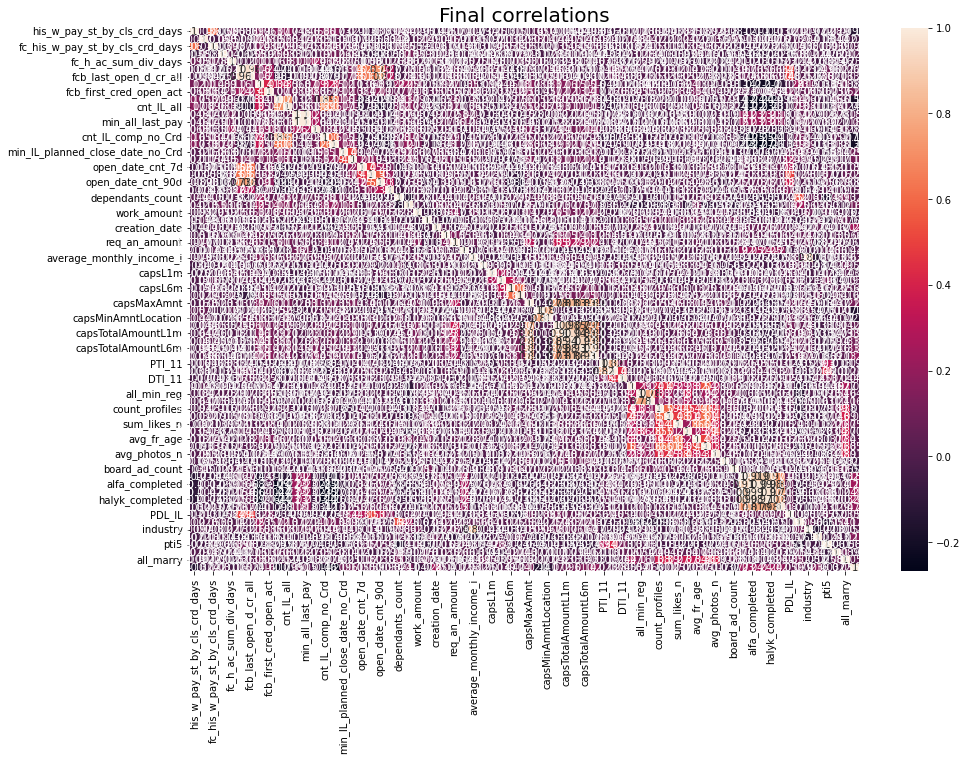

In [13]:
# Устанавливаем порого для фильтрации признаков по корреляциям.
# По дефолту 0.85 - оптимальное значение, в зависимости от требований
# можно поставить число в диапозоне 0.75 - 0.9.
cut_off = 0.85
X_train_corr = delete_correlated_features(X, cut_off=cut_off, is_plot_prev=False,
                                          exclude=[], IV_sort=True, iv_df=iv_df)

In [14]:
X = X[X_train_corr.columns]
X.columns = 'WOE_' + X.columns

In [15]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по date_requested (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества месяцев большего num_bad_months.
# Т.е. например, если gini_min=0.05 и num_bad_months=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.05  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_months = 2  # 2 месяца по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
date_name = 'date_requested'  # Дата, по которой делить на месяцы.

gini_feats, df_gini_months = gini_month_selection(X, df, gini_min=gini_min,
                                                  num_bad_months=num_bad_months, date_name=date_name)
len(gini_feats)

54

In [16]:
# Отбираем признаки по их значимости во время построения Деревьев решений.
top_n = 50  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
rf_feats, rf_imp = rf_feature_selection(X[gini_feats], y, top_n=top_n)

In [17]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 35  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
tf_feats, tf_imp = permutation_two_forest_selection(X[rf_feats], y, top_n=top_n)

In [18]:
# Итоговый набор переменных, который будет учавтсовать в построении дерева.
vars = [var.replace('WOE_', '') for var in tf_feats]

### Делаем подготовку данных перед построением дерева

In [19]:
# !pip install category-encoders

  Using cached category_encoders-2.3.0-py2.py3-none-any.whl (82 kB)


In [20]:
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [21]:
df_base = df.copy()
# df = df_base.copy()

In [22]:
cat_feat = df[vars].select_dtypes(include=object).columns
num_feat = df[vars].select_dtypes(exclude=object).columns

In [23]:
# Кодируем категориальный переменные.
target_encoder = ce.target_encoder.TargetEncoder(smoothing=0.1)
df[cat_feat] = target_encoder.fit_transform(df[cat_feat], df[TARGET])

# Составляем таблицы соответсвия при кодировани, чтобы можно было декодировать значения.
dict_of_encoding = {}
for feat in cat_feat:
    target_encoder = ce.target_encoder.TargetEncoder(smoothing=0.1)
    target_encoder.fit(df[[feat]], df[TARGET])

    values = df[[feat]].drop_duplicates()
    encoding = target_encoder.transform(values)

    dict_of_encoding[feat] = pd.concat([encoding, values], axis=1).reset_index(drop=True)

In [24]:
# Заполняем NaN значения медианой данного количественного признака
for feat in num_feat:
    df[feat].fillna(df[feat].median(), inplace=True)

### Строим дерево решений

В каждом прямоугольнике расположена следующая информация:
* решающее правило для разделения на следующем уровне, например: fcb_first_cred_open <= 83.0
* количество объектов в данном узле: samples = 1740
* размеры классов: value = [1688 (количество класса 0), 52 (количество класса 1)]

Далее на следующей уровне будет разделение по текущему правилу. Объекты, удовлетворяющие ему пойдут влево, другие пойдут вправо.

Так после правила "fcb_first_cred_open <= 83.0" влевом узле будут объекты, для которых это верно (value=[48, 12]), остальные пойдут в правый узел (value=[1640, 40]).

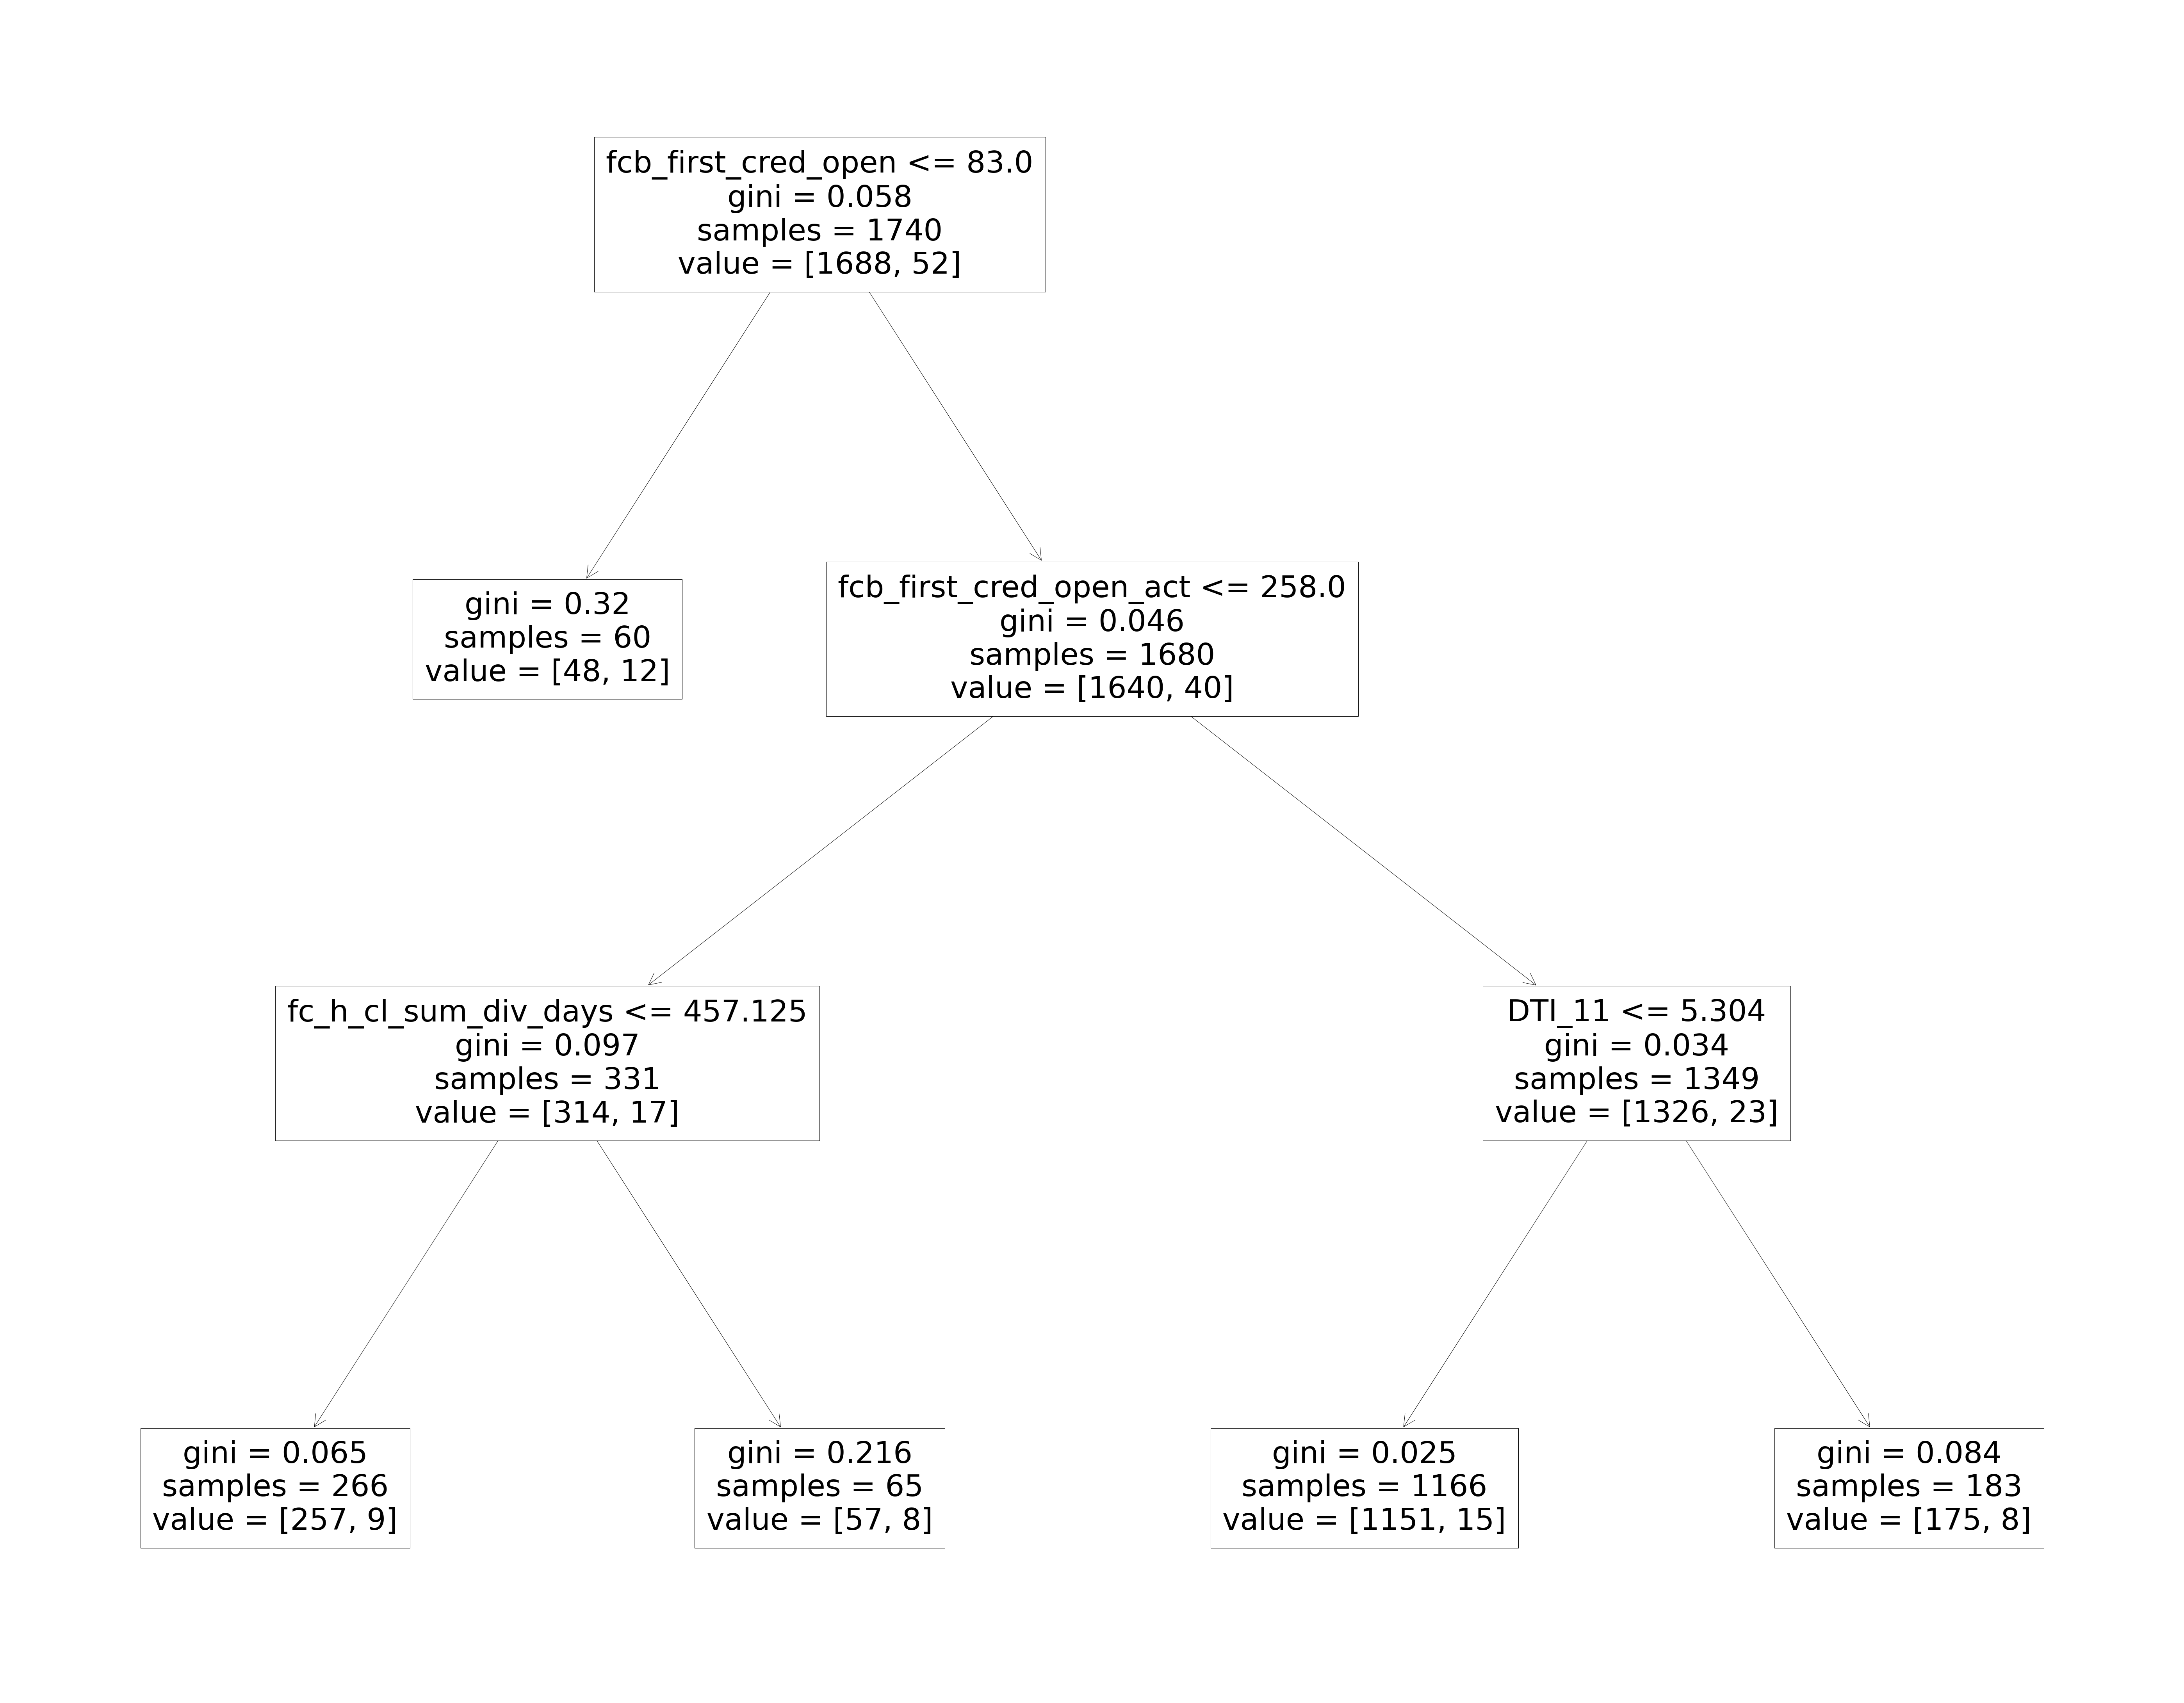

In [25]:
min_samples_leaf = 60  # Минимальное количество объектов в одном листе дерева.
max_depth = 3  # Максимальная глубина дерева.
pic_name = 'result_rules/example_tree_structure_v1.png'  # Где и под каким именем сохранять картинку

clf_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=142)
clf_tree.fit(df[vars], df[TARGET])

fig = plt.figure(figsize=(100,80))
_ = tree.plot_tree(clf_tree, 
                   feature_names=vars,  
                  #  class_names=['good', 'bad'],
                #    filled=True
                   )
fig.savefig(pic_name)

In [26]:
num_forests = 4  # Количество деревьев с разным случайным набором признаков.
min_samples_leaf = 60  # Минимальное количество объектов в одном листе дерева.
max_depth = 3  # Максимальная глубина дерева.
percent_feat = 0.7  # Процент признаков, который брать для построения нового дерева.
pic_name = 'result_rules/example_tree_structure2_v.png'  # Где и под каким именем сохранять картинки


for i in range(1, num_forests+1):
    __vars = [np.random.choice(vars) for i in range(int(len(vars) * percent_feat))]
    clf_tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=142)
    clf_tree.fit(df[__vars], df[TARGET])

    fig = plt.figure(figsize=(100,80))
    _ = tree.plot_tree(clf_tree, 
                    feature_names=vars,  
                    #  class_names=['good', 'bad'],
                    #    filled=True
                    )
    fig.savefig(pic_name[:-4] + str(i) + pic_name[-4:])
    # plt.show()  # чтобы отрисовывать деревья
    plt.close()  # чтобы не отрисовывать деревья